In [308]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
%load_ext nengo.ipynb

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


In [309]:
dt = 0.001
seed = 0

pre_nrn = 4
post_nrn = 2

pre_params = dict(encoders=[[1], [1], [-1], [-1]], intercepts=[-0.1, 0, 0, -0.1], max_rates=[250, 300, 300, 250], seed=seed)
post_params = dict(encoders=[[1], [-1]], intercepts=[-0.05, -0.05], max_rates=[200, 200], seed=seed)

def stim_func(t):
    if (t % 0.5) * 2 > 0.5:
        return 0.3
    else:
        return -0.3

lr = 5e-10

In [310]:
with nengo.Network() as tmp_model:
    pre = nengo.Ensemble(pre_nrn, 1, **pre_params)
    post = nengo.Ensemble(post_nrn, 1, **post_params)
    conn = nengo.Connection(pre, post, solver=nengo.solvers.LstsqL2(weights=True), seed=seed)

with nengo.Simulator(tmp_model) as tmp_sim:
    pass

weights = tmp_sim.data[conn].weights * post.radius / tmp_sim.data[post].gain[:, None]

A Jupyter Widget

# Real (for comparison)

In [311]:
with nengo.Network() as real_model:
    sin = nengo.Node(stim_func)

    pre = nengo.Ensemble(4, 1, **pre_params)
    post = nengo.Ensemble(2, 1, **post_params)

    nengo.Connection(sin, pre)
    conn = nengo.Connection(
        pre.neurons, post.neurons, transform=weights)

    conn.learning_rule_type = nengo.BCM(learning_rate=lr)

    real_model.p_weights = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.1)
    real_model.p_wout = nengo.Probe(conn, synapse=0.01)
    real_model.p_out = nengo.Probe(post, synapse=0.01)

In [312]:
with nengo.Simulator(real_model) as real_sim:
    real_sim.run(10.0)

A Jupyter Widget

A Jupyter Widget

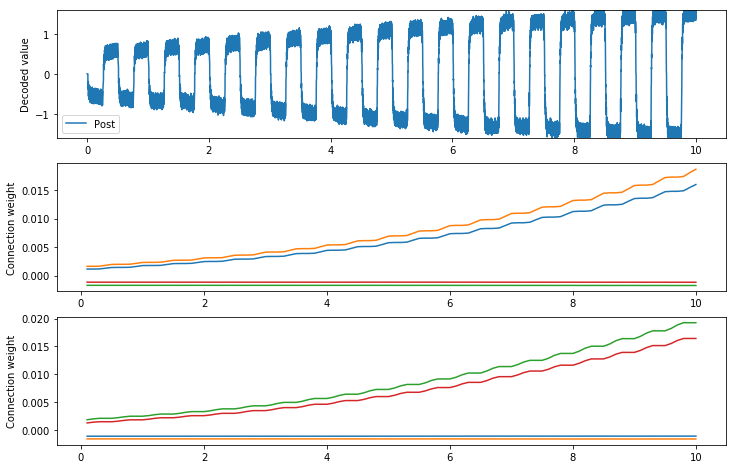

In [300]:

plt.subplot(3, 1, 2)
plt.plot(sim.trange(dt=0.1), sim.data[p_weights][:, 0])
plt.ylabel("Connection weight");
plt.subplot(3, 1, 3)
plt.plot(sim.trange(dt=0.1), sim.data[p_weights][:, -1])
plt.ylabel("Connection weight");

# Fake

In [313]:
class FakeBCM(object):

    def __init__(self, learning_rate=1e-9, in_neurons=4, out_neurons=2, theta_tau=1.0,
                 sample_every=0.1, start_weights=None):
        self.kappa = learning_rate * dt
        assert start_weights is not None
        self.omega = start_weights.copy()
        self.in_nrns = in_neurons
        self.lowpass = nengo.Lowpass(theta_tau).make_step(out_neurons, out_neurons, dt, None)
        self.weight_history = []
        self.period = sample_every / dt

    def bcm_func(self, t, x):
        in_rates = x[:self.in_nrns]
        out_rates = x[self.in_nrns:]
        theta = self.lowpass(t, out_rates)

        self.omega += np.outer(self.kappa * out_rates * (out_rates - theta), in_rates)

        if (t / dt % self.period) < 1:
            self.weight_history.append(self.omega.copy())

        return np.dot(self.omega, in_rates)

In [314]:
with nengo.Network() as fake_model:
    sin = nengo.Node(stim_func)
    
    pre = nengo.Ensemble(pre_nrn, 1, **pre_params)
    post = nengo.Ensemble(post_nrn, 1, **post_params)

    fake_bcm = FakeBCM(in_neurons=pre_nrn, out_neurons=post_nrn, learning_rate=lr, start_weights=weights)
    learn = nengo.Node(fake_bcm.bcm_func, size_in=pre_nrn+post_nrn, size_out=post_nrn)

    nengo.Connection(sin, pre)

    nengo.Connection(pre.neurons, learn[:pre_nrn], synapse=0.005)
    nengo.Connection(post.neurons, learn[pre_nrn:], synapse=0.005)
    nengo.Connection(learn, post.neurons, synapse=None)

    fake_model.p_nd = nengo.Probe(learn, synapse=0.01)
    fake_model.p_out = nengo.Probe(post, synapse=0.01)

In [315]:
with nengo.Simulator(fake_model) as fake_sim:
    fake_sim.run(10)

A Jupyter Widget

A Jupyter Widget

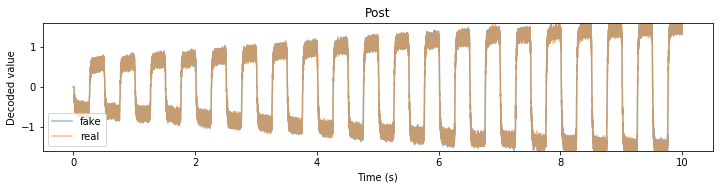

In [318]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(fake_sim.trange(), fake_sim.data[fake_model.p_out], label="fake", alpha=0.5)
plt.plot(fake_sim.trange(), real_sim.data[real_model.p_out], label="real", alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")
plt.title("Post")

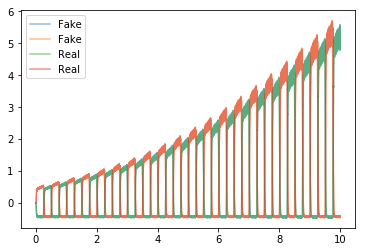

In [320]:
plt.plot(fake_sim.trange(), fake_sim.data[fake_model.p_nd], label="Fake", alpha=0.5)
plt.plot(real_sim.trange(), real_sim.data[real_model.p_wout], label="Real", alpha=0.5)
plt.legend()

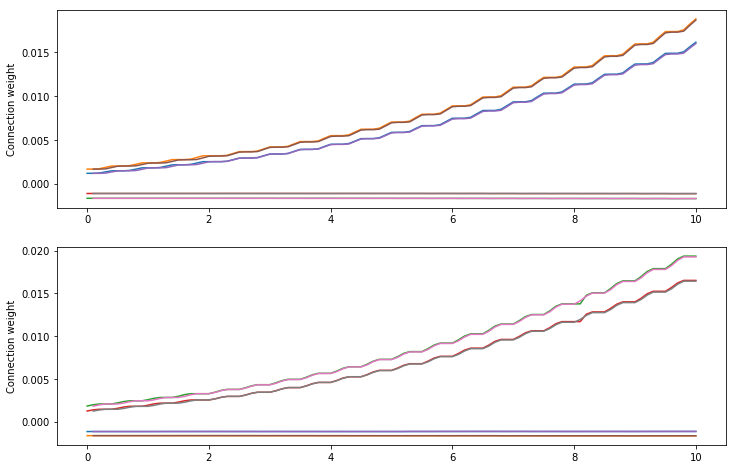

In [323]:
plt.figure(figsize=(12, 8))

w_hist = np.array(fake_bcm.weight_history)
w_hist_trange = np.concatenate(([0], fake_sim.trange(dt=0.1),))

plt.subplot(2, 1, 1)
plt.plot(w_hist_trange, w_hist[:, 0])
plt.plot(real_sim.trange(dt=0.1), real_sim.data[real_model.p_weights][:, 0])
plt.ylabel("Connection weight");
plt.subplot(2, 1, 2)
plt.plot(w_hist_trange, w_hist[:, -1])
plt.plot(real_sim.trange(dt=0.1), real_sim.data[real_model.p_weights][:, -1])
plt.ylabel("Connection weight");